In [1]:
from   fundopt.fundopt import FundTargetRetMinCVaROptimiser, FundTargetRetMinVarianceOptimiser
import pandas   as pd
import numpy    as np
import datetime as dt
import cvxpy as cvx
import logging

In [2]:
start = dt.date(2020, 1, 1)
end   = dt.date(2021, 5, 21)
holding =  20

fund_returns = pd.read_pickle('./{}_{}_{}.pkl'.format(start, end, holding))

# Not tradeable
fund_returns.drop(['003064'], axis=1, inplace=True)

In [3]:
lookback_start = dt.date(2020, 5, 21)
lookback_end   = dt.date(2021, 5, 21)
lookback = pd.bdate_range(lookback_start, lookback_end)

print( f"Look back period from {lookback.min()} to {lookback.max()}" )
print( "Top 5 high return funds:")
print( fund_returns.reindex(lookback).fillna(0.0).mean(axis=0).sort_values(ascending=False).head() )

opt = FundTargetRetMinCVaROptimiser(
    targetRet=0.05, 
    returns=fund_returns)

current=pd.Series(dtype=float)
current['163406'] = 117108.0
current['020005'] = 44499.0

solver_options = { 
    'verbose' : True,
    'solver'  : cvx.GLPK,
 }
opt_trade = opt.getOptimalPosition(current, lookbackPeriod=lookback, solver_options=solver_options)

Look back period from 2020-05-21 00:00:00 to 2021-05-21 00:00:00
Top 5 high return funds:
002190    0.067913
540008    0.066255
001643    0.064898
001644    0.064492
090018    0.064084
dtype: float64
                                     CVXPY                                     
                                    v1.1.12                                    
(CVXPY) May 23 02:08:18 PM: Your problem has 3525 variables, 3 constraints, and 1 parameters.
(CVXPY) May 23 02:08:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 23 02:08:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 23 02:08:19 PM: Compiling problem (target solver=GLPK).
(CVXPY) May 23 02:08:19 PM

In [6]:
target_rets = np.arange(0.01, 0.06, 0.001)

In [7]:
solver_options = { 
    'verbose' : False,
    'solver'  : cvx.GLPK,
 }

In [8]:
res = []
for ret in target_rets:
    opt.set_target_ret_and_rerun(ret, solver_options)
    print(ret, opt.cvxProblem.value)
    res.append((ret, opt.cvxProblem.value))

0.01 -599.274924450539
0.011 -599.2749244505387
0.011999999999999999 -599.2749244505387
0.012999999999999998 -599.2749244505387
0.013999999999999997 -599.2749244505387
0.014999999999999996 -599.2749244505387
0.015999999999999993 -599.2749244505387
0.016999999999999994 -599.2749244505387
0.017999999999999995 -599.2744055134986
0.018999999999999993 -590.3474598867746
0.01999999999999999 -579.090091890192
0.02099999999999999 -563.7383460811421
0.021999999999999992 -543.9600387640198
0.02299999999999999 -523.1217449172261
0.023999999999999987 -500.5586086811075
0.024999999999999988 -475.78815342330324
0.02599999999999999 -449.15138235494356
0.02699999999999999 -421.91155459309624
0.027999999999999983 -391.7048474770618
0.028999999999999984 -359.8572813012188
0.029999999999999985 -320.1000177389061
0.030999999999999986 -278.3361896573954
0.03199999999999998 -235.697988541607
0.03299999999999998 -192.8040940005409
0.03399999999999998 -149.91019945947508
0.03499999999999998 -107.0163049184096

In [9]:
import matplotlib.pyplot as plt

In [14]:
data = np.array(res)

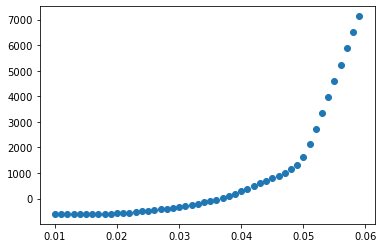

In [18]:
plt.scatter(data[:, 0], data[:, 1])

In [53]:
final = current.add(opt_trade, fill_value=0.0)

In [54]:
final = final[final.abs()>0.1]

In [55]:
from fundopt.fundtsloader import getTSLoader

In [56]:
rolled = {}
daily = {}
for symbol, value in final.iteritems():
    loader = getTSLoader(symbol)
    loader.load(lookback_start, lookback_end)
    ret_ts = loader.getReturnTS(lookback_start, lookback_end)
    rolled[symbol] = value * (1.+ret_ts).cumprod()

In [57]:
backtest = pd.DataFrame.from_dict( rolled )

<AxesSubplot:>

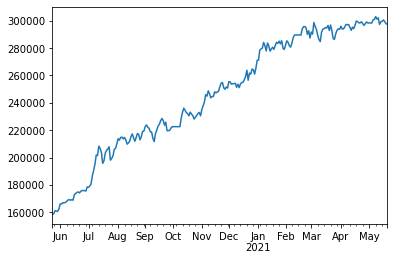

In [58]:
backtest.dropna().sum(axis=1).plot()

In [59]:
df1 = pd.read_pickle('2020-01-01_2021-05-21_20.pkl')
df2 = pd.read_pickle('2020-01-01_2021-05-21_20_v2.pkl')

In [63]:
df1.shape

(343, 3525)

In [69]:
new_symbols = df2.columns.difference(df1.columns)

<AxesSubplot:>

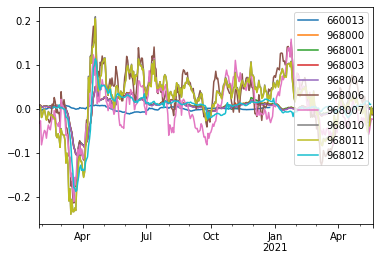

In [74]:
df2[new_symbols[-10:]].plot()

<AxesSubplot:>

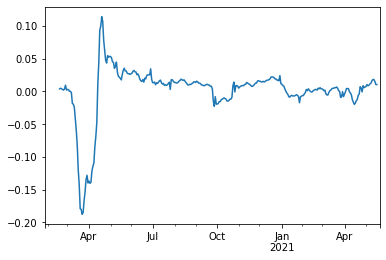

In [76]:
df2['968012'].plot()